In [2]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from dynamic_routing_analysis import spike_utils, plot_utils
import dynamic_routing_analysis as dra
import os

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [24]:
# load data
# regenerate_table=False
# all_data_loadpath=dra.SINGLE_UNIT_METRICS_PATH / "combined" / "all_data_plus_performance.pkl"
# all_data_loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"
all_data_loadpath=r"D:\CO single unit metrics\v272_2025-08-15\stim_context_lick_modulation.parquet"

# if regenerate_table:
#     savepath = dra.SINGLE_UNIT_METRICS_PATH / "combined"
#     stim_context_loadpath = dra.SINGLE_UNIT_METRICS_PATH
#     lick_loadpath = dra.SINGLE_UNIT_METRICS_PATH / "lick_modulation"
#     performance_loadpath = os.path.join(savepath,"performance_dict.pkl")
#     spike_utils.concat_single_unit_metrics_across_sessions(stim_context_loadpath=stim_context_loadpath,lick_loadpath=lick_loadpath,
#                                                            performance_loadpath=None,savepath=savepath)

# all_data = pd.read_pickle(all_data_loadpath)

all_data = pd.read_parquet(all_data_loadpath)

# #temp hack take first x characters of session id to match with dr_session_list
# all_data['session_id'] = all_data['session_id'].str.slice(0,17)

In [4]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [5]:
#temp hack take first x characters of session id to match with dr_session_list
all_data['session_id'] = all_data['session_id'].str.slice(0,17)

In [ ]:
sel_project='DynamicRouting'
sel_units=all_data.query('presence_ratio>=0.7 and \
                            isi_violations_ratio<=0.5 and \
                            amplitude_cutoff<=0.1 and \
                            activity_drift<=0.2 and \
                            project.str.contains(@sel_project) and \
                            ~structure.isna() and ~location.isna() and \
                            session_id in @dr_session_list')


adj_pvals=spike_utils.calculate_single_unit_metric_adjusted_pvals(sel_units,sel_project)

In [ ]:
all_data.query('(structure=="SNr") and session_id in @dr_session_list and activity_drift<=0.2 and \
                isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1')['session_id'].value_counts()

session_id
703880_2024-04-15    35
649943_2023-02-15    16
708016_2024-04-29    15
737403_2024-09-26    15
686176_2023-12-07    12
733891_2024-09-19    12
733891_2024-09-17    10
733891_2024-09-18    10
714748_2024-06-26     9
649943_2023-02-16     8
750329_2024-11-27     8
733891_2024-09-16     7
660023_2023-08-09     3
741148_2024-10-18     2
743199_2024-12-04     2
737403_2024-09-24     1
Name: count, dtype: int64

## stimulus modulation

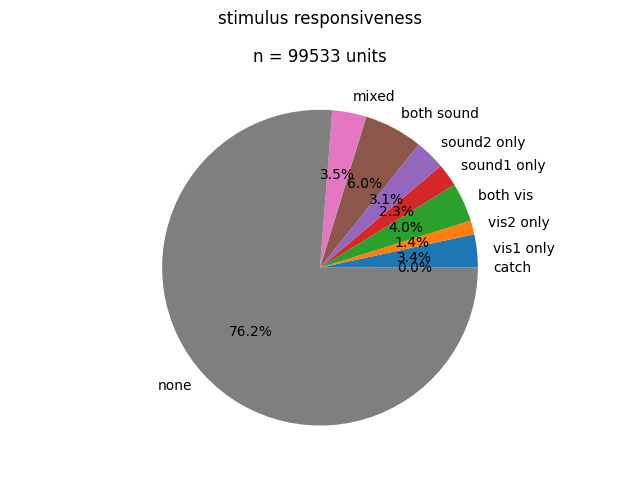

In [8]:
#plot overall stimulus modulation
plot_utils.plot_stimulus_modulation_pie_chart(adj_pvals,sel_project)

In [9]:
#calculate stimulus modulation by region
area_fraction_responsive_to_stim = spike_utils.calculate_stimulus_modulation_by_area(sel_units,sel_project,plot_figures=False,savepath=None)

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1305: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.023318042813455658' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_responsive_to_stim.iloc[rr,1:-5]=row.iloc[1:-5]/row['total_n']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1305: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01118119266055046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_responsive_to_stim.iloc[rr,1:-5]=row.iloc[1:-5]/row['total_n']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1305: FutureWarning: Setting an item of incompatible dtype is de

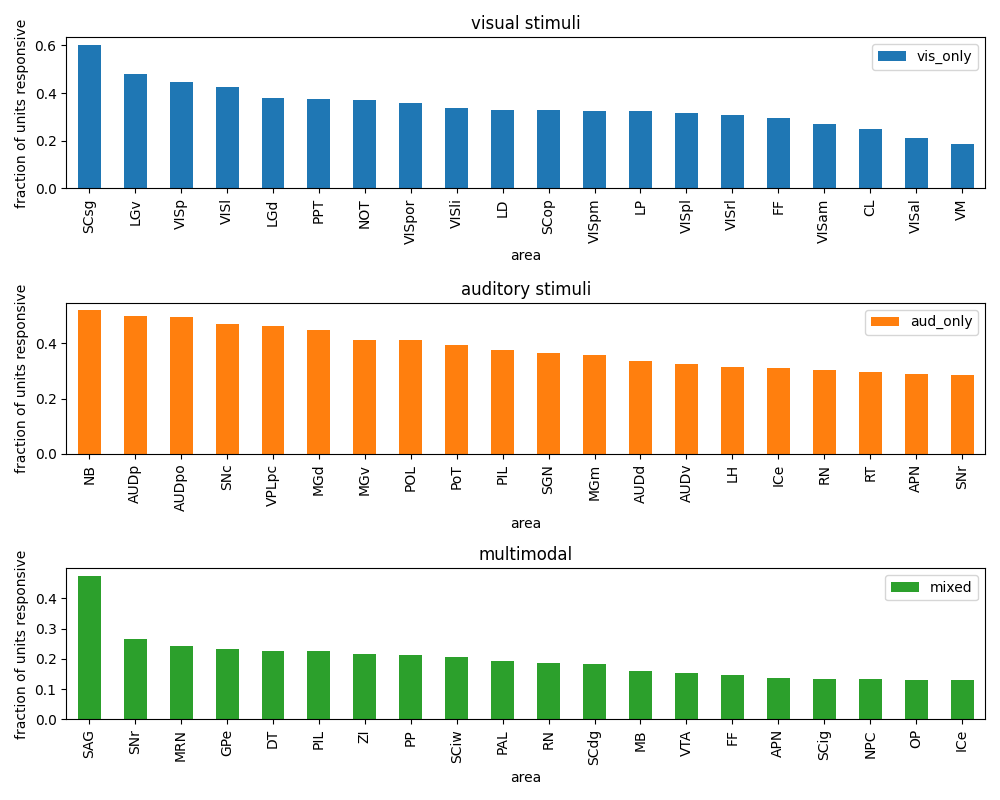

In [10]:
#plot top 20 stimulus modulated regions

#stimulus:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#vis: vis1+vis1+both_vis
vis_resp=area_fraction_responsive_to_stim[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_responsive_to_stim['vis_only']=vis_resp
sort_by_vis=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=3').sort_values(by='vis_only',ascending=False).head(20)
sort_by_vis[['area','vis_only']].plot.bar(ax=ax[0],x='area',y='vis_only',color='tab:blue')
ax[0].set_title('visual stimuli')
ax[0].set_ylabel('fraction of units responsive')

#aud: sound1+sound2+both_sound
aud_resp=area_fraction_responsive_to_stim[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_responsive_to_stim['aud_only']=aud_resp
sort_by_aud=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=3').sort_values(by='aud_only',ascending=False).head(20)
sort_by_aud[['area','aud_only']].plot.bar(ax=ax[1],x='area',y='aud_only',color='tab:orange')
ax[1].set_title('auditory stimuli')
ax[1].set_ylabel('fraction of units responsive')

#mixed: mixed
sort_by_mixed=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=3').sort_values(by='mixed',ascending=False).head(20)
sort_by_mixed[['area','mixed']].plot.bar(ax=ax[2],x='area',y='mixed',color='tab:green')
ax[2].set_title('multimodal')
ax[2].set_ylabel('fraction of units responsive')

fig.tight_layout()


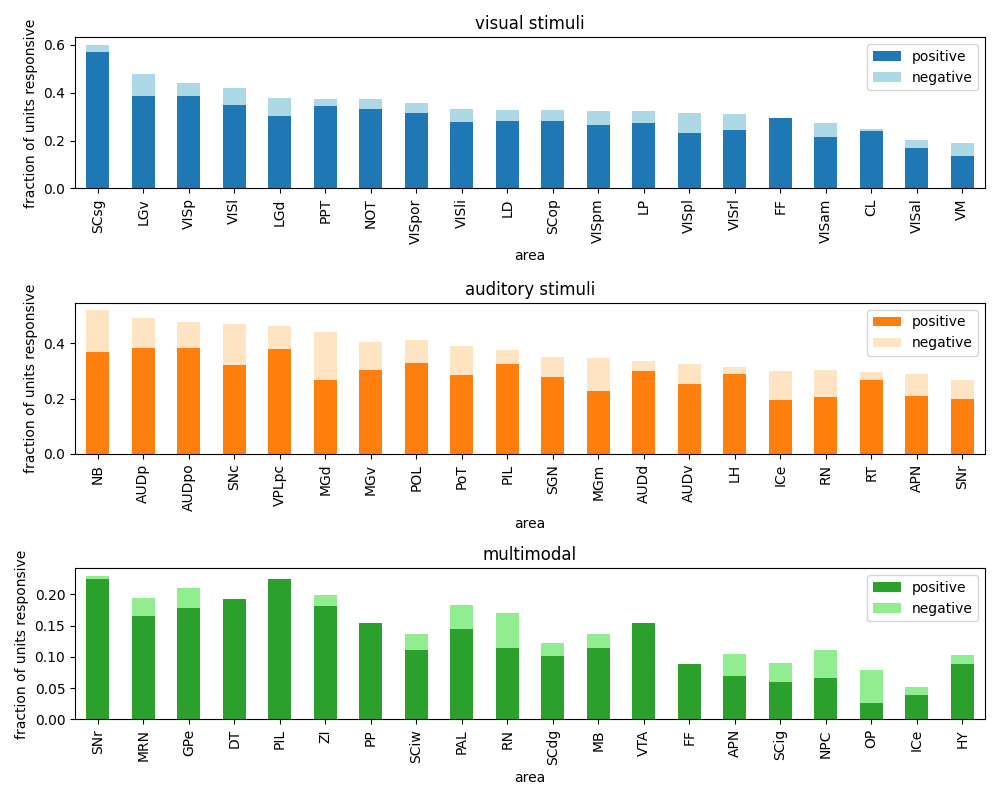

In [11]:
#plot top 20 stimulus modulated areas, including sign of modulation

#stimulus:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#vis: vis1+vis1+both_vis
vis_pos_resp=area_fraction_responsive_to_stim[['vis1_pos','vis2_pos','both_vis_pos']].sum(axis=1)
area_fraction_responsive_to_stim['vis_pos_only']=vis_pos_resp
vis_neg_resp=area_fraction_responsive_to_stim[['vis1_neg','vis2_neg','both_vis_neg']].sum(axis=1)
area_fraction_responsive_to_stim['vis_neg_only']=vis_neg_resp
vis_resp=area_fraction_responsive_to_stim[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_responsive_to_stim['vis_only']=vis_resp

sort_by_vis=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=4').sort_values(by='vis_only',ascending=False).head(20)
sort_by_vis[['area','vis_pos_only','vis_neg_only']].plot.bar(ax=ax[0],x='area',stacked=True,color=['tab:blue','lightblue'])
ax[0].set_title('visual stimuli')
ax[0].set_ylabel('fraction of units responsive')
ax[0].legend(['positive','negative'])

#aud: sound1+sound2+both_sound
aud_pos_resp=area_fraction_responsive_to_stim[['sound1_pos','sound2_pos','both_sound_pos']].sum(axis=1)
area_fraction_responsive_to_stim['aud_pos_only']=aud_pos_resp
aud_neg_resp=area_fraction_responsive_to_stim[['sound1_neg','sound2_neg','both_sound_neg']].sum(axis=1)
area_fraction_responsive_to_stim['aud_neg_only']=aud_neg_resp
aud_resp=area_fraction_responsive_to_stim[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_responsive_to_stim['aud_only']=aud_resp

sort_by_aud=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=4').sort_values(by='aud_only',ascending=False).head(20)
sort_by_aud[['area','aud_pos_only','aud_neg_only']].plot.bar(ax=ax[1],x='area',stacked=True,color=['tab:orange','bisque'])
ax[1].set_title('auditory stimuli')
ax[1].set_ylabel('fraction of units responsive')
ax[1].legend(['positive','negative'])

#mixed: mixed
mixed_pos_resp=area_fraction_responsive_to_stim[['mixed_pos']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_pos_only']=mixed_pos_resp
mixed_neg_resp=area_fraction_responsive_to_stim[['mixed_neg']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_neg_only']=mixed_neg_resp
mixed_resp=area_fraction_responsive_to_stim[['mixed']].sum(axis=1)
area_fraction_responsive_to_stim['mixed_only']=mixed_resp

sort_by_mixed=area_fraction_responsive_to_stim.query('total_n>=30 and n_sessions>=4').sort_values(by='mixed',ascending=False).head(20)
sort_by_mixed[['area','mixed_pos_only','mixed_neg_only']].plot.bar(ax=ax[2],x='area',stacked=True,color=['tab:green','lightgreen'])
ax[2].set_title('multimodal')
ax[2].set_ylabel('fraction of units responsive')
ax[2].legend(['positive','negative'])

fig.tight_layout()


## context, stimulus, and lick modulation

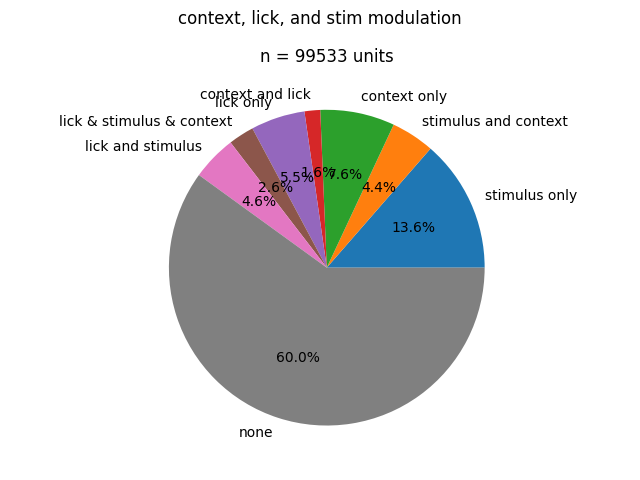

In [12]:
# #plot overall context, stim, lick modulation
plot_utils.plot_context_stim_lick_modulation_pie_chart(adj_pvals,sel_project)

In [13]:
#calculate context, lick, stimulus modulation by region
area_fraction_context_mod=spike_utils.compute_context_stim_lick_modulation_by_area(sel_units,sel_project,plot_figures=False,savepath=None)

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1471: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26337920489296635' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_context_mod.iloc[rr,1:-5]=row.iloc[1:-5]/row['total_n']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1471: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1014908256880734' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_context_mod.iloc[rr,1:-5]=row.iloc[1:-5]/row['total_n']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1471: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

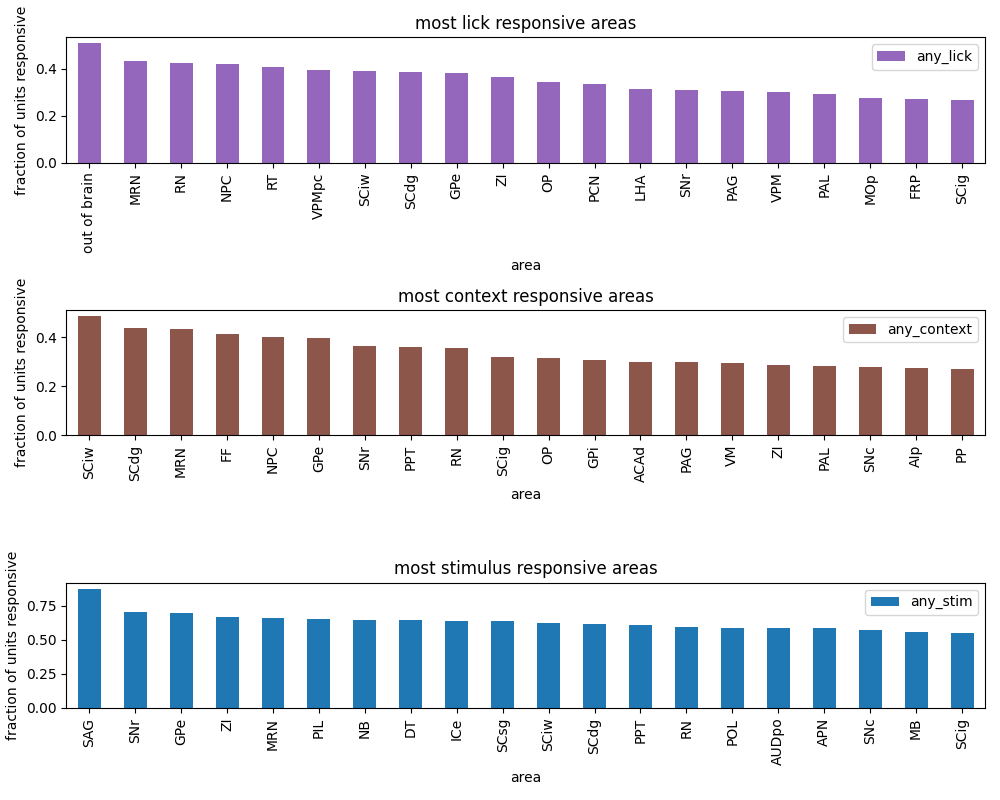

In [14]:
#lick/context/stim:
fig,ax=plt.subplots(3,1,figsize=(10,8))
#lick: any lick
sort_by_lick=area_fraction_context_mod.query('total_n>=30 and n_sessions>=3').sort_values(by='any_lick',ascending=False).head(20)
sort_by_lick[['area','any_lick']].plot.bar(ax=ax[0],x='area',y='any_lick',color='tab:purple')
ax[0].set_title('most lick responsive areas')
ax[0].set_ylabel('fraction of units responsive')

#context: any context
sort_by_context=area_fraction_context_mod.query('total_n>=30 and n_sessions>=3').sort_values(by='any_context',ascending=False).head(20)
sort_by_context[['area','any_context']].plot.bar(ax=ax[1],x='area',y='any_context',color='tab:brown')
ax[1].set_title('most context responsive areas')
ax[1].set_ylabel('fraction of units responsive')

#stim: any stim
sort_by_stim=area_fraction_context_mod.query('total_n>=30 and n_sessions>=3').sort_values(by='any_stim',ascending=False).head(20)
sort_by_stim[['area','any_stim']].plot.bar(ax=ax[2],x='area',y='any_stim',color='tab:blue')
ax[2].set_title('most stimulus responsive areas')
ax[2].set_ylabel('fraction of units responsive')


fig.tight_layout()

## context modulation of stimulus responses

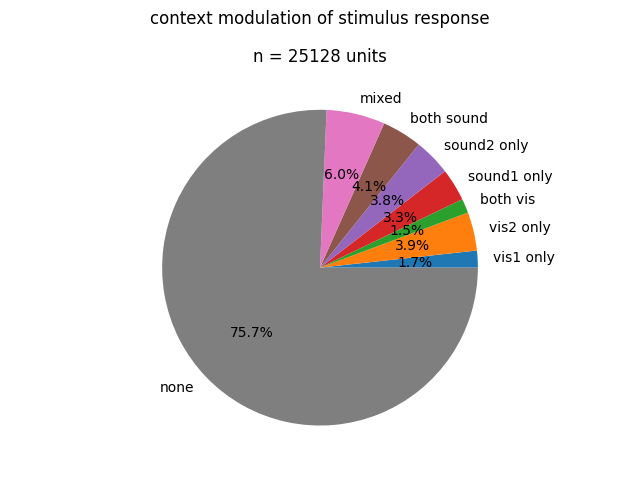

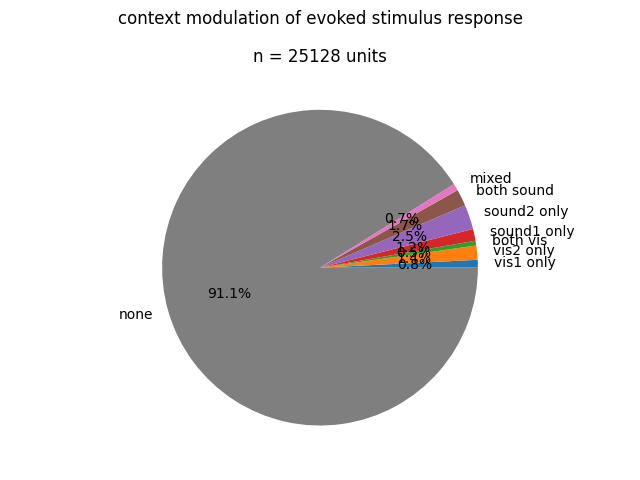

In [15]:
#plot stimulus responses modulated by context
plot_utils.plot_context_mod_stim_resp_pie_chart(adj_pvals,sel_project,savepath=None)

In [16]:
area_fraction_context_stim_mod=spike_utils.calculate_context_mod_stim_resp_by_area(sel_units,sel_project,plot_figures=False,savepath=None)

C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1603: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.027213352685050797' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_context_stim_mod.iloc[rr,1:-4]=row.iloc[1:-4]/row['n_stim_responsive']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1603: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04753265602322206' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  area_fraction_context_stim_mod.iloc[rr,1:-4]=row.iloc[1:-4]/row['n_stim_responsive']
C:\Users\ethan.mcbride\Code\dynamic_routing_analysis\src\dynamic_routing_analysis\spike_utils.py:1603: FutureWarning: Setting an item of incompat

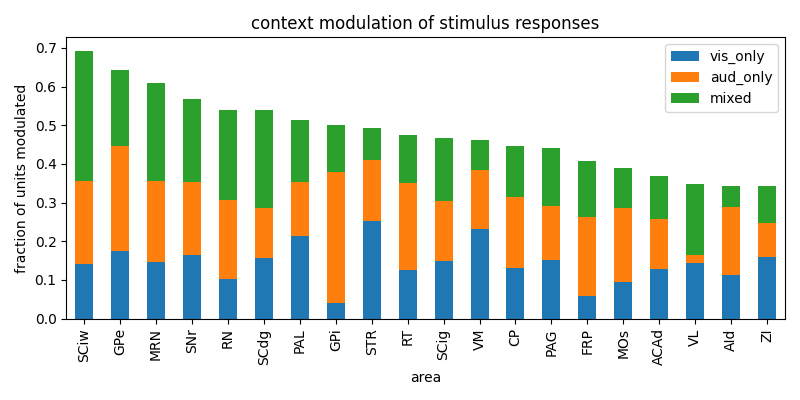

In [17]:
#context modulation of stimulus
fig,ax=plt.subplots(1,1,figsize=(8,4))
#vis: vis1+vis2+both_vis
vis_context_stim_mod=area_fraction_context_stim_mod[['vis1','vis2','both_vis']].sum(axis=1)
area_fraction_context_stim_mod['vis_only']=vis_context_stim_mod

#aud: sound1+sound2+both_sound
aud_context_stim_mod=area_fraction_context_stim_mod[['sound1','sound2','both_sound']].sum(axis=1)
area_fraction_context_stim_mod['aud_only']=aud_context_stim_mod

#total frac responsive
area_fraction_context_stim_mod['any_stim']=area_fraction_context_stim_mod[['vis1','vis2','sound1','sound2','mixed','both_vis','both_sound']].sum(axis=1)

sort_by_any_context_mod_stim=area_fraction_context_stim_mod.query('n_stim_responsive>=40 and n_sessions>=4 and not area.str.islower()').sort_values(by='any_stim',ascending=False).head(20)
sort_by_any_context_mod_stim[['area','vis_only','aud_only','mixed']].plot.bar(ax=ax,x='area',y=['vis_only','aud_only','mixed'],stacked=True)
ax.set_title('context modulation of stimulus responses')
ax.set_ylabel('fraction of units modulated')

fig.tight_layout()

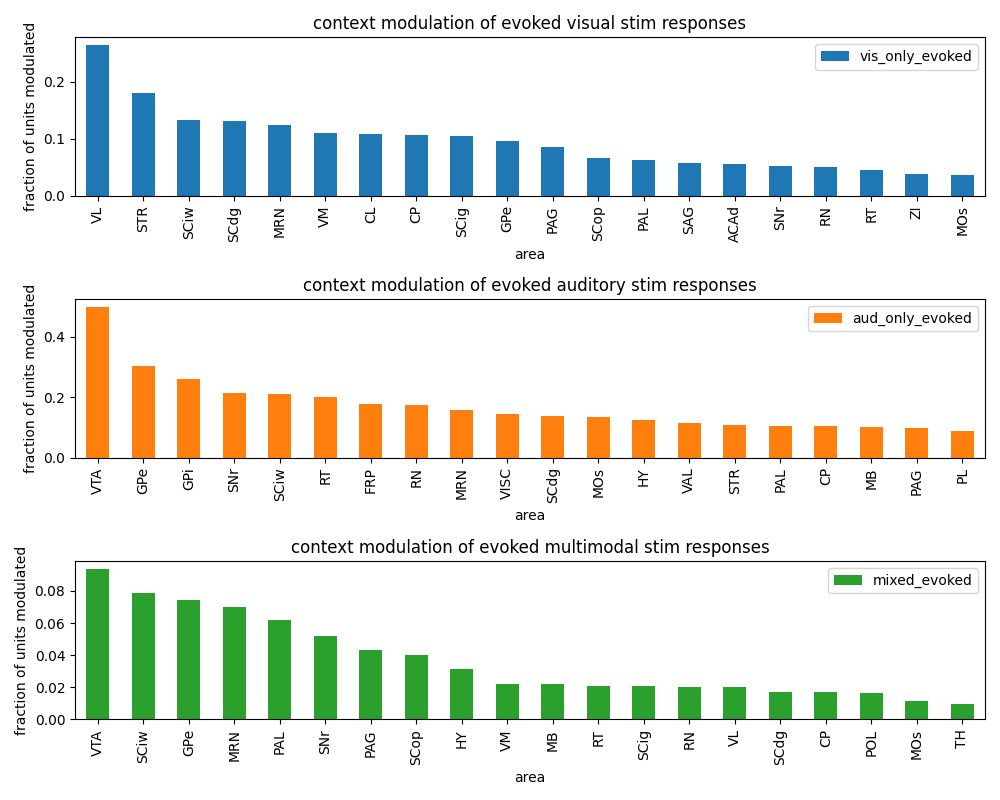

In [18]:
#context modulation of evoked stimulus
fig,ax=plt.subplots(3,1,figsize=(10,8))
#vis: vis1+vis2+both_vis
vis_context_evoked_stim_mod=area_fraction_context_stim_mod[['vis1_evoked','vis2_evoked','both_vis_evoked']].sum(axis=1)
area_fraction_context_stim_mod['vis_only_evoked']=vis_context_evoked_stim_mod
sort_by_vis_context_evoked_stim=area_fraction_context_stim_mod.query('n_stim_responsive>=30 and n_sessions>=3').sort_values(by='vis_only_evoked',ascending=False).head(20)
sort_by_vis_context_evoked_stim[['area','vis_only_evoked']].plot.bar(ax=ax[0],x='area',y='vis_only_evoked',color='tab:blue')
ax[0].set_title('context modulation of evoked visual stim responses')
ax[0].set_ylabel('fraction of units modulated')

#aud: sound1+sound2+both_sound
aud_context_evoked_stim_mod=area_fraction_context_stim_mod[['sound1_evoked','sound2_evoked','both_sound_evoked']].sum(axis=1)
area_fraction_context_stim_mod['aud_only_evoked']=aud_context_evoked_stim_mod
sort_by_aud_context_evoked_stim=area_fraction_context_stim_mod.query('n_stim_responsive>=30 and n_sessions>=3').sort_values(by='aud_only_evoked',ascending=False).head(20)
sort_by_aud_context_evoked_stim[['area','aud_only_evoked']].plot.bar(ax=ax[1],x='area',y='aud_only_evoked',color='tab:orange')
ax[1].set_title('context modulation of evoked auditory stim responses')
ax[1].set_ylabel('fraction of units modulated')

#mixed: mixed
sort_by_mixed_context_evoked_stim=area_fraction_context_stim_mod.query('n_stim_responsive>=30 and n_sessions>=3').sort_values(by='mixed_evoked',ascending=False).head(20)
sort_by_mixed_context_evoked_stim[['area','mixed_evoked']].plot.bar(ax=ax[2],x='area',y='mixed_evoked',color='tab:green')
ax[2].set_title('context modulation of evoked multimodal stim responses')
ax[2].set_ylabel('fraction of units modulated')

fig.tight_layout()

In [19]:
#Layer diffs

In [ ]:
#RS vs FS

In [ ]:
#raw vs evoked context modulation

In [ ]:
#stim vs baseline context modulation

In [20]:
sel_units.columns

Index(['index', 'activity_drift', 'amplitude', 'amplitude_cutoff',
       'amplitude_cv_median', 'amplitude_cv_range', 'amplitude_median',
       'ccf_ap', 'ccf_dv', 'ccf_ml',
       ...
       'catch_evoked_context_modulation_index',
       'catch_stimulus_modulation_roc_auc',
       'catch_stimulus_late_modulation_roc_auc',
       'catch_context_modulation_roc_auc',
       'catch_evoked_context_modulation_roc_auc', 'lick_modulation_zscore',
       'lick_modulation_index', 'lick_modulation_p_value',
       'lick_modulation_sign', 'lick_modulation_roc_auc'],
      dtype='object', length=205)

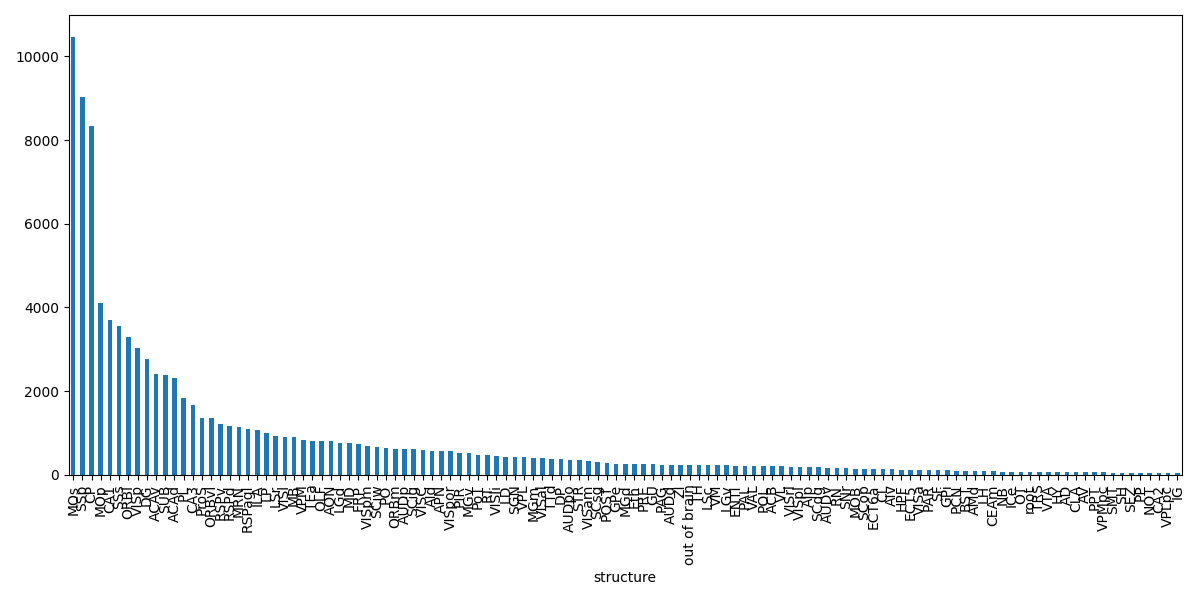

In [21]:
unit_counts=sel_units['structure'].value_counts()
unit_counts=unit_counts[unit_counts>=50]

fig,ax=plt.subplots(figsize=(12,6))
unit_counts.plot.bar(ax=ax)
fig.tight_layout()